In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# import flax.linen as nn
# from flax.training import train_state
# from clu import metrics
# import flax
# import optax

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/


In [8]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# meshes = []
# for idx in range(1,22):
#     mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [9]:
fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'
fork_scale = knife_scale = 1.0
box_scale = 1e-3
table_scale = 1e-6
mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
scales = (fork_scale, knife_scale, box_scale, table_scale)
for mesh_path, scale in zip(mesh_paths, scales):
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

Centering mesh with translation [-0.02541  -0.022295  0.007042]
Centering mesh with translation [-0.019428  -0.0274155  0.003918 ]


In [10]:
b.RENDERER.model_box_dims

Array([[1.9755599e-01, 2.7109999e-02, 1.5883999e-02],
       [2.1483001e-01, 2.0605002e-02, 2.2614000e-02],
       [7.1730003e-02, 1.6397701e-01, 2.1348599e-01],
       [1.0000000e-06, 1.0000000e-06, 1.0000000e-06]], dtype=float32)

In [11]:
def viz_trace_rendered_observed(trace):
    return b.viz.hstack_images(
        [
            b.viz.scale_image(b.get_depth_image(b.genjax.get_rendered_image(trace)[...,2]), 2),
            b.viz.scale_image(b.get_depth_image(trace["image"][...,2]), 2)
        ]
    )

In [12]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.genjax.model.importance)
update_jit = jax.jit(b.genjax.model.update)
enumerators = b.genjax.make_enumerator(["contact_params_2"])

In [13]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    fig = plt.figure(constrained_layout=True)
    fig.suptitle(f"is_fork: {is_fork}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.bar(["knife", "fork"], bars)
    ax.set_ylim(0.0, 1.0)
    return fig

In [14]:
key = jax.random.PRNGKey(0)

In [15]:
# CHEESEITZ_BOX_IDX = 1
# FORK_IDX = 17 # XXX
# SPOON_IDX = 17 # XXX

In [16]:
# CHEESEITZ_BOX_CONTACT_PARAMS = [0.0, 0.2, 0.0]

In [17]:
#SHIFT_MIN = -0.1
#SHIFT_SCALE = 0.5

In [18]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3

In [34]:
SHIFT_MIN = -0.2
SHIFT_SCALE = 0.4
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.2, 0.0])

In [35]:
def fork_spoon_generator(key):
    is_fork = jax.random.bernoulli(key)
    shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)

    #indices = jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX if is_fork else KNIFE_IDX])
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift, 0, jnp.pi/2]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return (is_fork, rendered)
fork_spoon_generator_jit = jax.jit(fork_spoon_generator)

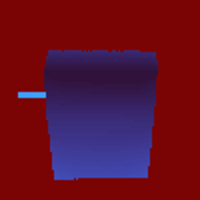

In [36]:
key = jax.random.split(key, 1)[0]
observation = fork_spoon_generator_jit(key)[1][...,:3]
b.viz.scale_image(b.get_depth_image(observation[...,2]), 2)

In [37]:
b.clear()
b.show_trimesh("1", b.RENDERER.meshes[FORK_IDX])
b.show_trimesh("2", b.RENDERER.meshes[KNIFE_IDX])


In [38]:
contact_param_grid = jax.vmap(
    lambda shift: jnp.array([shift, 0, jnp.pi/2])
)(jnp.linspace(SHIFT_MIN, SHIFT_MIN+SHIFT_SCALE, 2000))

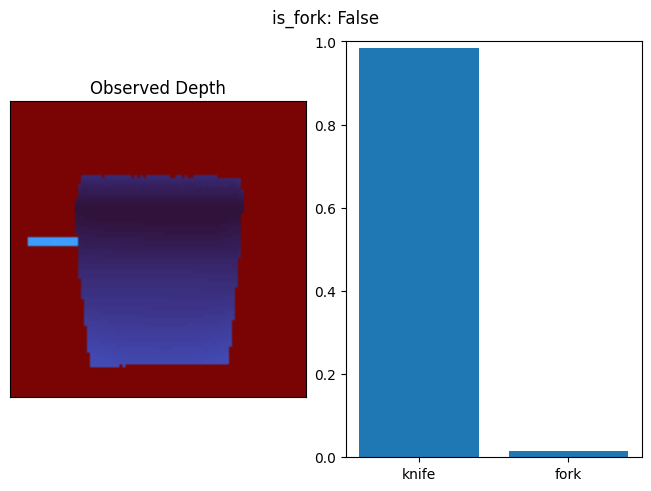

In [40]:
# pathlib.Path('knife_fork_results').mkdir(parents=True, exist_ok=True) 
# for experiment_iteration in tqdm(range(1)):
key = jax.random.split(key, 1)[0]
is_fork, observation = fork_spoon_generator_jit(key)

weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "id_0": jnp.int32(3),
    "id_1": jnp.int32(CHEESEITZ_BOX_IDX),
    "id_2": jnp.int32(FORK_IDX),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "variance": 0.001,
    "outlier_prob": 0.001,
    "image": observation[...,:3],
    "contact_params_1": CHEESEITZ_BOX_CONTACT_PARAMS
    # "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(3),
    jnp.arange(4),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-2.0, -2.1, -2*jnp.pi]), jnp.array([2.1, 2.1, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0)
)

trace = update_jit(key, trace, genjax.choice_map({"id_2": KNIFE_IDX}), b.genjax.make_unknown_change_argdiffs(trace))[2]
weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])

trace = update_jit(key, trace, genjax.choice_map({"id_2": FORK_IDX}), b.genjax.make_unknown_change_argdiffs(trace))[2]
weights2 = enumerators[3](trace,key,contact_param_grid)
best_trace = enumerators[0](trace, key, contact_param_grid[weights2.argmax()])

fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


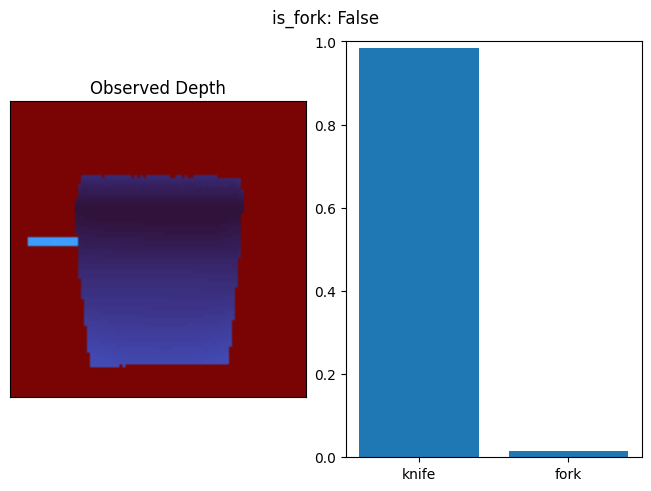

In [58]:
trace = update_jit(key, trace, genjax.choice_map({"id_2": KNIFE_IDX}), b.genjax.make_unknown_change_argdiffs(trace))[2]
weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace1 = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])

trace = update_jit(key, trace, genjax.choice_map({"id_2": FORK_IDX}), b.genjax.make_unknown_change_argdiffs(trace))[2]
weights2 = enumerators[3](trace,key,contact_param_grid)
best_trace2 = enumerators[0](trace, key, contact_param_grid[weights2.argmax()])
fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))


In [51]:
def likelihood_per_pixel(trace):
    return b.threedp3_likelihood_per_pixel_jit(
        trace["image"],
        b.genjax.get_rendered_image(trace),
        trace["variance"],
        trace["outlier_prob"],
        trace.get_args()[-1],
        3
    )

In [53]:
pixel_scores1 = likelihood_per_pixel(best_trace1)
pixel_scores2 = likelihood_per_pixel(best_trace2)

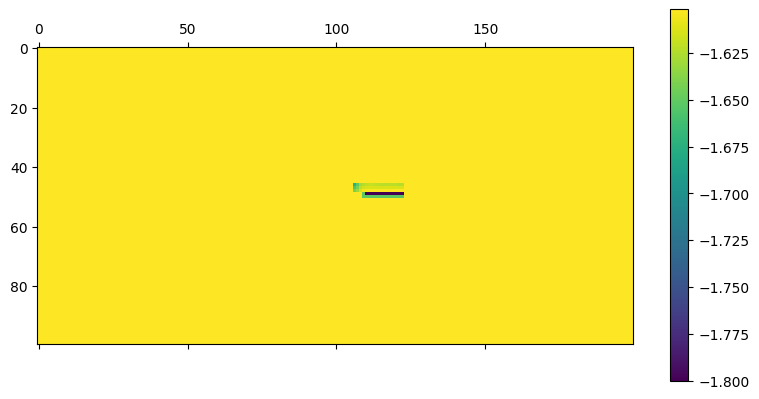

In [73]:
plt.matshow(jnp.hstack([pixel_scores1, pixel_scores2]))
plt.colorbar()

In [84]:
distances_1 = get_closest_point(
    best_trace1["image"],
    b.genjax.get_rendered_image(best_trace1),
    4
)

distances_2 = get_closest_point(
    best_trace2["image"],
    b.genjax.get_rendered_image(best_trace2),
    4
)


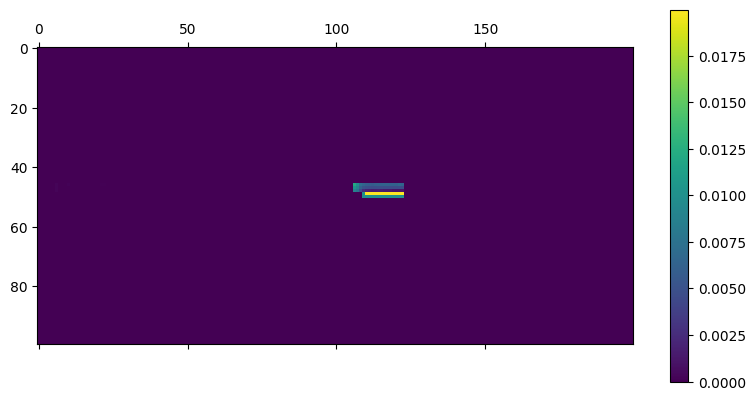

In [85]:
plt.matshow(jnp.hstack([distances_1, distances_2]))
plt.colorbar()

In [79]:
import functools
@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,3,),
)
def closest_point_vectorize(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz_padded: jnp.ndarray,
    filter_size: int,
):
    distances = (
        observed_xyz[ij[0], ij[1], :3] - 
        jax.lax.dynamic_slice(rendered_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    )
    distances_norm = jnp.linalg.norm(distances, axis=-1)
    return distances_norm.min()

def get_closest_point(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    filter_size
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    closest_distance = closest_point_vectorize(
        indices,
        observed_xyz,
        rendered_xyz_padded,
        filter_size
    )
    return closest_distance

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [75]:
print(pixel_scores2.min())
i,j = jnp.unravel_index(pixel_scores2.argmin(),pixel_scores2.shape)
print(pixel_scores2[i,j])
print(trace["image"][i,j])

-1.8004537
-1.8004537
[-0.39999998 -0.01        2.        ]


In [62]:
best_trace1["image"][pixel_scores1.argmin(),:]

Array([[-0.5       ,  0.48999998,  2.        ],
       [-0.48999998,  0.48999998,  2.        ],
       [-0.48      ,  0.48999998,  2.        ],
       [-0.47      ,  0.48999998,  2.        ],
       [-0.45999998,  0.48999998,  2.        ],
       [-0.45      ,  0.48999998,  2.        ],
       [-0.44      ,  0.48999998,  2.        ],
       [-0.42999998,  0.48999998,  2.        ],
       [-0.42      ,  0.48999998,  2.        ],
       [-0.41      ,  0.48999998,  2.        ],
       [-0.39999998,  0.48999998,  2.        ],
       [-0.39      ,  0.48999998,  2.        ],
       [-0.38      ,  0.48999998,  2.        ],
       [-0.37      ,  0.48999998,  2.        ],
       [-0.35999998,  0.48999998,  2.        ],
       [-0.35      ,  0.48999998,  2.        ],
       [-0.34      ,  0.48999998,  2.        ],
       [-0.32999998,  0.48999998,  2.        ],
       [-0.32      ,  0.48999998,  2.        ],
       [-0.31      ,  0.48999998,  2.        ],
       [-0.29999998,  0.48999998,  2.   

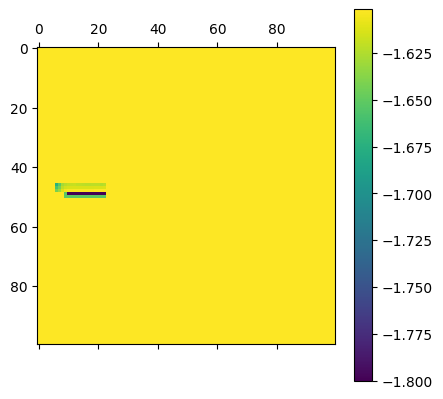

In [61]:
plt.matshow(pixel_scores2)
plt.colorbar()

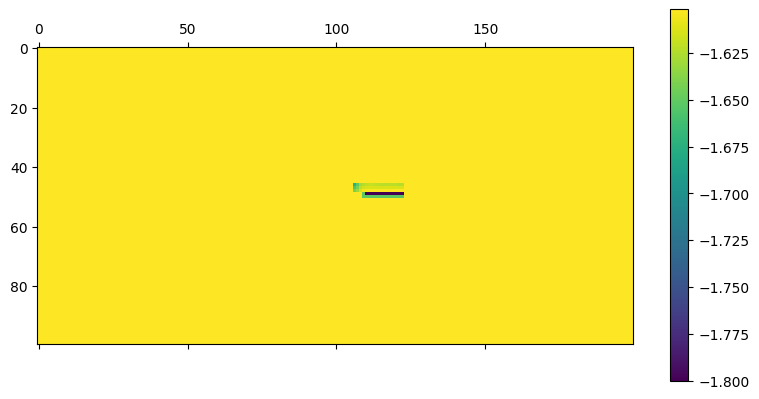

In [59]:
plt.matshow(jnp.hstack([pixel_scores1, pixel_scores2]))
plt.colorbar()

In [244]:
b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()]))

Array([0.54849017, 0.45139608], dtype=float32)

In [237]:
b.clear()
b.show_pose("1", table_pose)
b.show_trimesh("2", b.RENDERER.meshes[CHEESEITZ_BOX_IDX])
b.set_pose("2", b.genjax.get_poses(trace)[1])


In [50]:
is_forks, imgs = zip(*map(fork_spoon_generator, batch_keys))

(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)
(3, 4, 4)


[2626306094 3398223712]


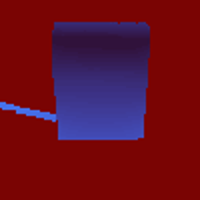

In [31]:
key = jax.random.split(key, 1)[1]
print(key)
_, img = fork_spoon_generator(key)
b.viz.scale_image(b.get_depth_image(img[...,2]), 2)

## CNN Inference

C1: conv with 10x10 filter stride 3 32 channels (input 100x100x1, output 31 x 31 x 32)

relu (input 31 x 31 x 32, output 31 x 31 x 32)

max pooling 3x3 stride 2 32 channels (input 31 x 31 x 32, output 15 x 15x 32)

C2: conv with 5x5 filter stride 2 64 channels (input 15 x 15 x 32, output 6 x 6 x 64)

relu (input 6 x 6 x 64, output 6 x 6 x 64)

max pooling 2x2 stride 2 64 channels (input 6 x 6 x 64, output 3 x 3 x 64)

flatten (input 3 x 3 x 64, output 1 x 576)

L1: linear (input 1 x 576, output 1x 576)

relu

L2: linear (input 1 x 576, output 1x 192)

relu

L3: linear (input 1 x 192, output 1x 24)

relu

L4: linear (input 1 x 24, output 1 x 2)

softmax

In [48]:
BATCH_SIZE = 2

In [138]:
class CNN(nn.Module):

    @nn.compact
    def __call__(self, imgs): # XXX todo: make sure the sizes all line up
        c1 = nn.Conv(32, (10, 10), strides=(3, 3), padding='VALID')(img)
        r1 = nn.activation.relu(c1)
        m1 = nn.max_pool(r1, (3, 3), strides=(2, 2))
        
        c2 = nn.Conv(64, (5, 5), strides=(2, 2), padding='VALID')(m1)
        r2 = nn.activation.relu(c2)
        m2 = nn.max_pool(r2, (2, 2), strides=(2, 2))
        
        l1 = nn.Dense(576)(m2.reshape(BATCH_SIZE, -1))
        r3 = nn.activation.relu(l1)

        l2 = nn.Dense(192)(r3)
        r4 = nn.activation.relu(l2)

        l3 = nn.Dense(24)(r4)
        r5 = nn.activation.relu(l3)

        l4 = nn.Dense(2)(r5)
        return l4 # nn.activation.softmax(l4)

In [141]:
cnn = CNN()
cnn.tabulate(jax.random.PRNGKey(0), jnp.zeros((BATCH_SIZE, 100, 100, 1)), console_kwargs={'force_jupyter': True})

                                          CNN Summary                                          
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs               ┃ outputs             ┃ params                      ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[2,100,100,1] │ float32[2,2]        │                             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_0  │ Conv   │ float32[2,100,100,1] │ float32[2,31,31,32] │ bias: float32[32]           │
│         │        │                      │                     │ kernel: float32[10,10,1,32] │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 3,232 (12.9 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_1  │ Conv   │ float32[2,15,15,32]  │ float32[2,6,6,64]   │ bias: float32[64]           │
│         │        │                      │                     │ kernel: float32[5,5,32,64]  │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 51,264 (205.1 KB)           │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_0 │ Dense  │ float32[2,576]       │ float32[2,576]      │ bias: float32[576]          │
│         │        │                      │                     │ kernel: float32[576,576]    │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 332,352 (1.3 MB)            │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_1 │ Dense  │ float32[2,576]       │ float32[2,192]      │ bias: float32[192]          │
│         │        │                      │                     │ kernel: float32[576,192]    │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 110,784 (443.1 KB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_2 │ Dense  │ float32[2,192]       │ float32[2,24]       │ bias: float32[24]           │
│         │        │                      │                     │ kernel: float32[192,24]     │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 4,632 (18.5 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_3 │ Dense  │ float32[2,24]        │ float32[2,2]        │ bias: float32[2]            │
│         │        │                      │                     │ kernel: float32[24,2]       │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 50 (200 B)                  │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│         │        │                      │               Total │ 502,314 (2.0 MB)            │
└─────────┴────────┴──────────────────────┴─────────────────────┴─────────────────────────────┘
                                                                                               
                              Total Parameters: 502,314 (2.0 MB)                               

'\n\n'

In [151]:
@flax.struct.dataclass
class Metrics(metrics.Collection):
    #accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')


In [152]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([BATCH_SIZE, 100, 100, 1]))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx, metrics=Metrics.empty())

In [153]:
make_onehot = lambda b: jax.lax.cond(b, lambda: jnp.array([0.0, 1.0]), lambda: jnp.array([1.0, 0.0]))

In [154]:
@jax.jit
def make_batch(key):
    keys = jax.random.split(key, BATCH_SIZE)
    is_forks, imgs = zip(*map(fork_spoon_generator, keys))
    img_batch = jnp.concatenate([img[:,:,2].reshape(1, 100, 100, 1) for img in imgs], 0)
    label_batch = jnp.array([make_onehot(is_fork) for is_fork in is_forks])
    return img_batch, label_batch

In [155]:
@jax.jit
def train_step(state, img_batch, label_batch): 
    """Train for a single step."""
    assert img_batch.shape == (BATCH_SIZE, 100, 100, 1)
    assert label_batch.shape == (BATCH_SIZE, 2) # one-hot labels
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, img_batch)
        loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=label_batch).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [156]:
@jax.jit
def compute_metrics(*, state, img_batch, label_batch):
    logits = state.apply_fn({'params': state.params}, img_batch)
    loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=label_batch).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label_batch, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [157]:
learning_rate = 0.01
momentum = 0.9
init_rng = jax.random.PRNGKey(0)
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [158]:
metrics_history = {'train_loss': []}
                   #'train_accuracy': []}

In [160]:
for step in range(100):
    img_batch, label_batch = make_batch(key)
    key = jax.random.split(key, 2)[0]
    
    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, img_batch, label_batch) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, img_batch=img_batch, label_batch=label_batch) # aggregate batch metrics
    
    for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch
    
    # Compute metrics on the test set after each training epoch
    
    print(f'train step: {step}, '
          f'loss: {metrics_history["train_loss"][-1]}')
          #f'accuracy: {metrics_history["train_accuracy"][-1] * 100}')

train step: 0, loss: 0.705607533454895
train step: 1, loss: 0.468073308467865
train step: 2, loss: 0.31490254402160645
train step: 3, loss: 0.8415378332138062
train step: 4, loss: 0.8033997416496277
train step: 5, loss: 0.7493113279342651
train step: 6, loss: 0.7857053279876709
train step: 7, loss: 0.6803973913192749
train step: 8, loss: 0.689419686794281
train step: 9, loss: 0.7037482857704163
train step: 10, loss: 0.6912602186203003
train step: 11, loss: 0.6923710107803345
train step: 12, loss: 0.6906137466430664
train step: 13, loss: 0.6906930208206177
train step: 14, loss: 0.6838263869285583
train step: 15, loss: 0.6927365064620972
train step: 16, loss: 0.6915008425712585
train step: 17, loss: 0.6926525831222534
train step: 18, loss: 0.7107948064804077
train step: 19, loss: 0.6918220520019531
train step: 20, loss: 0.6732577681541443
train step: 21, loss: 0.6910322904586792
train step: 22, loss: 0.7068942785263062
train step: 23, loss: 0.691716194152832
train step: 24, loss: 0.69052